In [1]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [3]:
def get_data(ticker, freq, high_param, train_length=500, test_size=0.05):
    conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
    data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
    conn.close()
    columns = ['open', 'high', 'low', 'close']
    for col in columns:
        data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
#     train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    split_len = int(len(data) * test_size)
    test_len = split_len + high_param
    test_data = data[-test_len:]
    train_data = data[-(train_length+split_len+high_param):-split_len]
    
    return train_data, test_data

In [4]:
def get_indicators(ticker, data, param_dict):
    indicators = {
        'SMA' : talib.SMA, 
        'EMA' : talib.EMA,
        'KAMA' : talib.KAMA, 
        'MIDPOINT' : talib.MIDPOINT, 
        'MIDPRICE' : talib.MIDPRICE, 
        'TRIMA' : talib.TRIMA, 
        'WMA' : talib.WMA,
             }

    for name, func in indicators.items():
        params = parameters[name][ticker]
        for i in range(2):
            if name == 'MIDPRICE':
                data[f"{name}_{i+1}"] = func(data['high'], data['low'], params[i])
            else:
                data[f"{name}_{i+1}"] = func(data['close'], params[i])
    
    return data

In [5]:
def get_signals(data):
    data.dropna(axis=0, inplace= True)
    signal_col = []
    for name in indicators.keys():
        data[f"{name}_signal"] = np.where(data[f"{name}_1"] > data[f"{name}_2"], 1,
                                 np.where(data[f"{name}_1"] < data[f"{name}_2"], -1, np.nan)) 
        # ffill NA --> avoid 2 statistic mode(s)
        data[f"{name}_signal"] = data[f"{name}_signal"].ffill().fillna(0)
        signal_col.append(f"{name}_signal")
    signals = data[signal_col].mode(axis=1)[0]
    
    return data, signals

In [6]:
freq = 'm15'
ticker = major_forex_pairs[0]
fname = f'../ta_optimize/json/OPTIMIZE_params_{freq}_100_20.json'
param_max = int(fname.split('_')[-2])
print(param_max)

with open(fname, 'r') as f:
    parameters = json.load(f)
# parameters

100


In [7]:
for k, v in parameters.items():
    print(k, v[ticker])

EMA [80, 100]
KAMA [40, 80]
MIDPOINT [40, 80]
MIDPRICE [40, 80]
SMA [40, 60]
TRIMA [40, 80]
WMA [80, 100]


In [8]:
train, test = get_data(ticker, freq, param_max)
use_train = True

if use_train:
    data = train
else:
    data = test

In [9]:
indicators = {'SMA' : talib.SMA, 
            'EMA' : talib.EMA,
            'KAMA' : talib.KAMA, 
            'MIDPOINT' : talib.MIDPOINT, 
            'MIDPRICE' : talib.MIDPRICE, 
            'TRIMA' : talib.TRIMA, 
            'WMA' : talib.WMA,
             }

for name, func in indicators.items():
    params = parameters[name][ticker]
    for i in range(2):
        d0 = datetime.now()
        if name == 'MIDPRICE':
            data[f"{name}_{i+1}"] = func(data['high'], data['low'], params[i])
        else:
            data[f"{name}_{i+1}"] = func(data['close'], params[i])
        print(f"{name} : {datetime.now() - d0}")

SMA : 0:00:00.000998
SMA : 0:00:00.000695
EMA : 0:00:00.000643
EMA : 0:00:00.000664
KAMA : 0:00:00.000559
KAMA : 0:00:00.000586
MIDPOINT : 0:00:00.000600
MIDPOINT : 0:00:00.000631
MIDPRICE : 0:00:00.000709
MIDPRICE : 0:00:00.000752
TRIMA : 0:00:00.000558
TRIMA : 0:00:00.000563
WMA : 0:00:00.000588
WMA : 0:00:00.000637


In [10]:
data.isna().sum().max()

99

In [11]:
data.dropna(axis=0, inplace= True)
signal_col = []
for name in indicators.keys():
    data[f"{name}_signal"] = np.where(data[f"{name}_1"] > data[f"{name}_2"], 1,
                                      np.where(data[f"{name}_1"] < data[f"{name}_2"], -1, np.nan)) #* -1
    # ffill NA --> avoid 2 statistic mode(s)
    data[f"{name}_signal"] = data[f"{name}_signal"].ffill().fillna(0)
    signal_col.append(f"{name}_signal")
signal_col

['SMA_signal',
 'EMA_signal',
 'KAMA_signal',
 'MIDPOINT_signal',
 'MIDPRICE_signal',
 'TRIMA_signal',
 'WMA_signal']

In [12]:
signals = data[signal_col].mode(axis=1).iloc[:, 0] #* -1
signals

date
2022-01-28 15:45:00   -1.0
2022-01-28 16:00:00   -1.0
2022-01-28 16:15:00    1.0
2022-01-28 16:30:00    1.0
2022-01-28 16:45:00    1.0
                      ... 
2022-02-04 17:30:00    1.0
2022-02-04 17:45:00    1.0
2022-02-04 18:00:00    1.0
2022-02-04 18:15:00    1.0
2022-02-04 18:30:00    1.0
Name: 0, Length: 501, dtype: float64

In [13]:
print(data.shape)
print(signals.shape)

(501, 34)
(501,)


In [14]:
print('*** Positions ***')
print(signals.value_counts())
print('-'*50)
print('*** Trades ***')
print(signals.diff(1).apply(np.abs).value_counts())

*** Positions ***
 1.0    456
-1.0     45
Name: 0, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    495
2.0      5
Name: 0, dtype: int64


  0%|          | 0/500 [00:00<?, ?it/s]

/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


*** EUR/USD ***


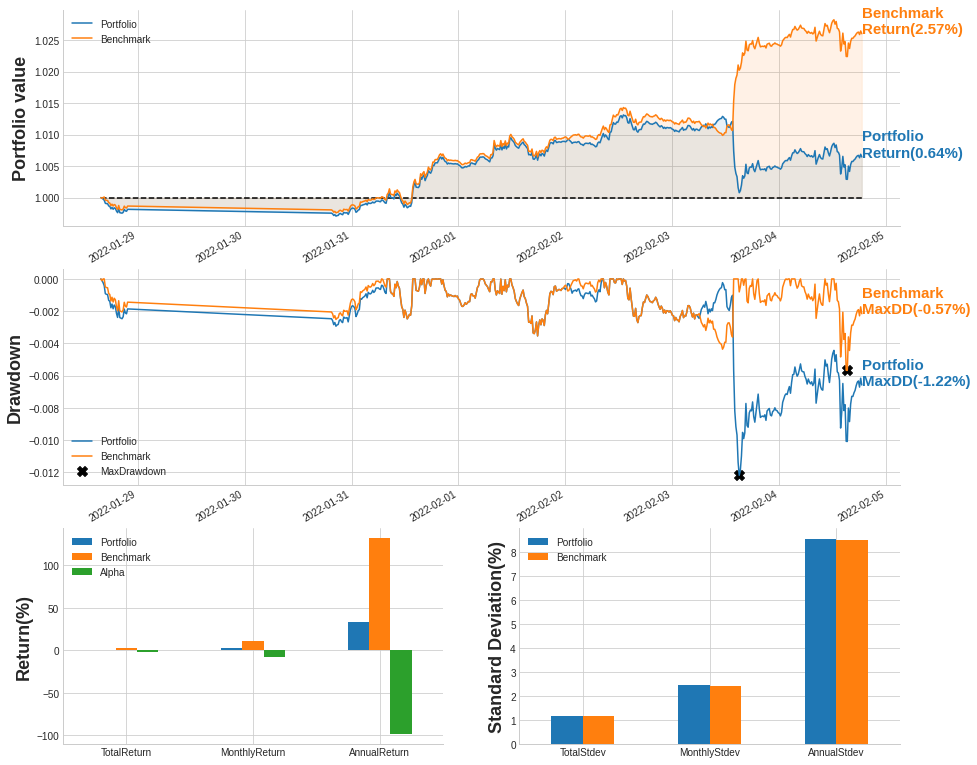

----------------------------------------------------------------------
Data length: |7 days 02:45:00|
Data range from |2022-01-28 15:45:00| to |2022-02-04 18:30:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       0.644 │       2.573 │  -1.929 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       2.716 │      10.849 │  -8.133 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      33.048 │     131.998 │ -98.950 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [15]:
backtester = IterativeBacktester(data=data, freq=freq, signals=signals)
backtester.backtest(leave=False)
print(f"*** {ticker} ***")
backtester.results()

/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype,

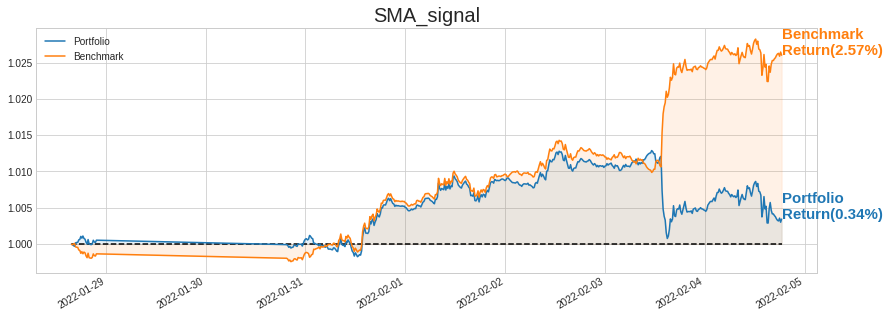

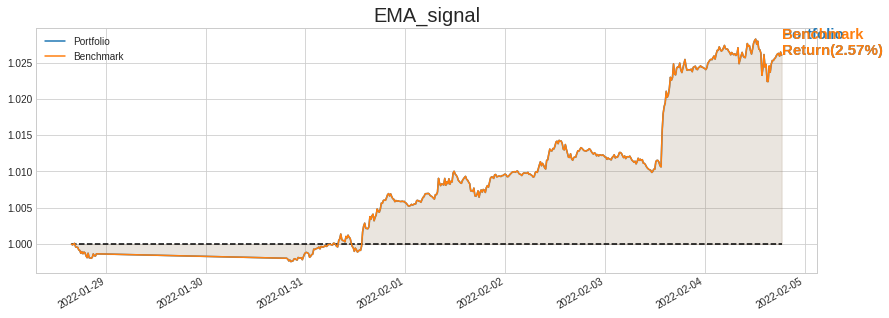

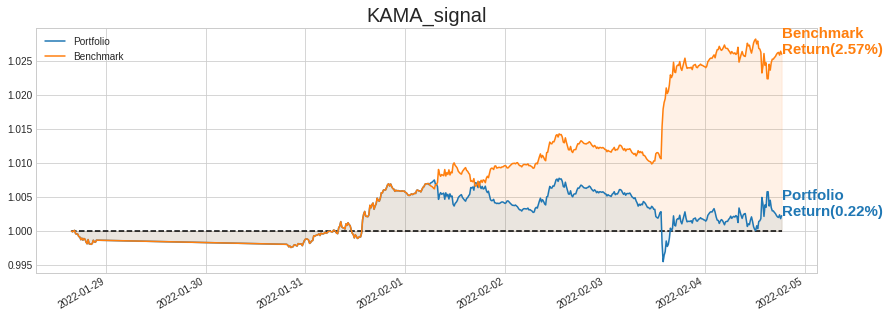

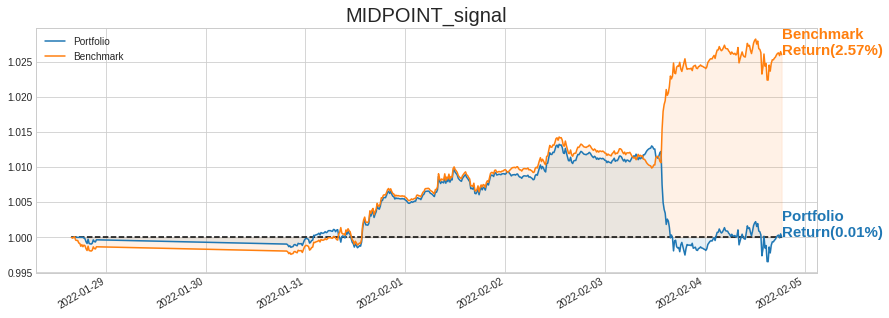

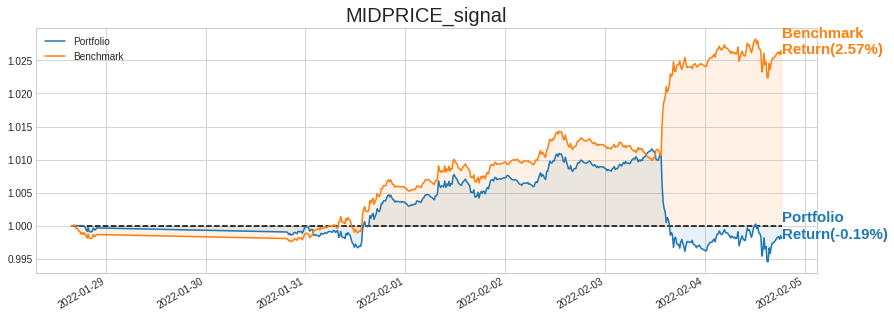

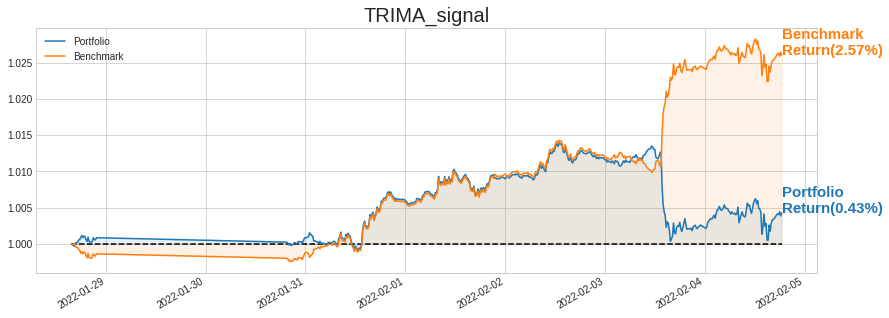

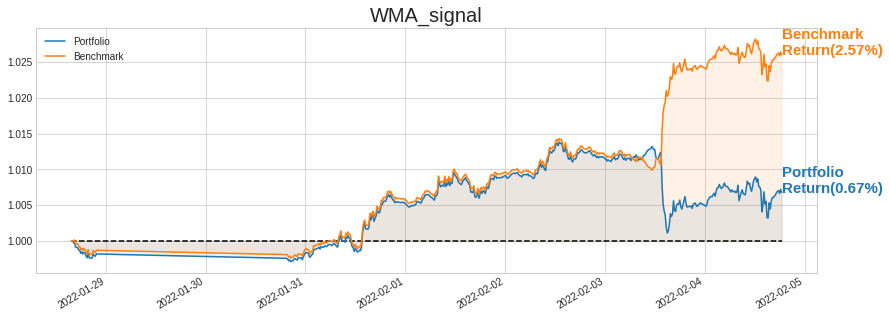

In [16]:
for sign in signal_col:
    backtest = IterativeBacktester(data, data[sign], freq)
    backtest.backtest(progress_bar=False)
    # print(sign)
    backtest.portfolio_df[['Portfolio', 'Benchmark']].plot(color=['tab:blue', 'tab:orange'], xlabel='', figsize=(14,5))
    plt.title(sign, fontsize=20)
    plt.hlines(backtest.init_money, xmin=backtest.portfolio_df.index[0], xmax=backtest.portfolio_df.index[-1], color='k', linestyle='--')
    plt.fill_between(x=backtest.portfolio_df.index, y1=backtest.portfolio_df['Portfolio'], y2=backtest.init_money, color='tab:blue', alpha=0.1)
    plt.fill_between(x=backtest.portfolio_df.index, y1=backtest.portfolio_df['Benchmark'], y2=backtest.init_money, color='tab:orange', alpha=0.1)
    plt.text(backtest.portfolio_df.index[-1], backtest.portfolio_df['Portfolio'][-1], f"Portfolio\nReturn({backtest.portfolio_df['PortfolioReturns'].sum()*100:.2f}%)", color="tab:blue", fontsize=15, fontweight="heavy")
    plt.text(backtest.portfolio_df.index[-1], backtest.portfolio_df['Benchmark'][-1], f"Benchmark\nReturn({backtest.portfolio_df['BenchmarkReturns'].sum()*100:.2f}%)", color="tab:orange", fontsize=15, fontweight="heavy")

In [17]:
def forex_backtest(freq, use_train, param_file):
    major_forex_pairs = ['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']
    returns = []
    param_max = int(fname.split('_')[-2])
    for ticker in tqdm_notebook(major_forex_pairs, leave=False):
        train, test = get_data(ticker, freq, param_max)

        if use_train:
            data = train
            print("use train data")
        else:
            data = test
            print("use test data")
   
        with open(fname, 'r') as f:
            parameters = json.load(f)

        data = get_indicators(ticker, data, parameters)
        data, signals = get_signals(data)
        print(f"{data.index[-1] - data.index[0]}")
        print(f"|{data.index[0]}| to |{data.index[-1]}|")
        backtester = IterativeBacktester(data=data, freq=freq, signals=signals)
        backtester.backtest(progress_bar=False)
        ret = backtester.return_df.loc['TotalReturn', 'Portfolio']
        returns.append(ret)
        print(f"{ticker} return: {ret*100:.2f}%")
        print("-"*30)
    print("="*30)
    print(f"Total return: {np.mean(returns)*100:.2f}%")

In [18]:
freq = 'm15'
use_train = False
fname = f'../ta_optimize/json/OPTIMIZE_params_{freq}_100_20.json'

forex_backtest(freq, use_train, fname)

  0%|          | 0/7 [00:00<?, ?it/s]

use test data
7 days 02:30:00
|2022-02-04 18:30:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


EUR/USD return: -0.39%
------------------------------
use test data
7 days 04:15:00
|2022-02-04 16:45:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


GBP/USD return: -1.00%
------------------------------
use test data
7 days 03:30:00
|2022-02-04 17:30:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


USD/JPY return: 0.56%
------------------------------
use test data
7 days 02:45:00
|2022-02-04 18:15:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


USD/CHF return: -0.64%
------------------------------
use test data
7 days 02:45:00
|2022-02-04 18:15:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


USD/CAD return: -1.12%
------------------------------
use test data
7 days 04:00:00
|2022-02-04 17:00:00| to |2022-02-11 21:00:00|


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


AUD/USD return: -0.46%
------------------------------
use test data
7 days 04:15:00
|2022-02-04 16:45:00| to |2022-02-11 21:00:00|
NZD/USD return: -0.05%
------------------------------
Total return: -0.44%


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
